## Projeto - Otimização de Alocação de Recursos com Clusterização



**Descrição**: Análise de segmentação de colaboradores para alocação estratégica em projetos


**Autor**: Ivan Ajala

In [2]:
# importação das bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.stats as stats
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Configurações visuais

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

#### 1. CARREGAMENTO E EXPLORAÇÃO DOS DADOS

In [10]:
print("=" * 60)
print("ANÁLISE DE SEGMENTAÇÃO DE COLABORADORES")
print("=" * 60)

# Carregar dados
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

print("\n1. PRIMEIRA VISUALIZAÇÃO DOS DADOS:")
print(f"Dimensões do dataset: {df.shape}")
print(f"\nColunas disponíveis:")
print(df.columns.tolist())
print(f"\nPrimeiras 5 linhas:")
df.head()

ANÁLISE DE SEGMENTAÇÃO DE COLABORADORES

1. PRIMEIRA VISUALIZAÇÃO DOS DADOS:
Dimensões do dataset: (1470, 35)

Colunas disponíveis:
['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Primeiras 5 linhas:


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


#### 2. ANÁLISE EXPLORATÓRIA (EDA) - ESTATÍSTICA DESCRITIVA

In [14]:
print("\n" + "=" * 60)
print("ESTATÍSTICA DESCRITIVA - VARIÁVEIS RELEVANTES")
print("=" * 60)

# Selecionando features relevantes para clusterização

features = ['JobSatisfaction', 'PerformanceRating', 'YearsAtCompany', 
           'TotalWorkingYears', 'YearsInCurrentRole', 'YearsSinceLastPromotion']

# Estatística descritiva
desc_stats = df[features].describe()
desc_stats


ESTATÍSTICA DESCRITIVA - VARIÁVEIS RELEVANTES


,JobSatisfaction,PerformanceRating,YearsAtCompany,TotalWorkingYears,YearsInCurrentRole,YearsSinceLastPromotion
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,2.728571,3.153741,7.008163,11.279592,4.229252,2.187755
std,1.102846,0.360824,6.126525,7.780782,3.623137,3.222430
min,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.000000,3.000000,6.000000,2.000000,0.000000
50%,3.000000,3.000000,5.000000,10.000000,3.000000,1.000000
75%,4.000000,3.000000,9.000000,15.000000,7.000000,3.000000
max,4.000000,4.000000,40.000000,40.000000,18.000000,15.000000


In [15]:
# Análise de distribuição
print(f"\nAnálise de distribuição:")
for feature in features:
    skewness = stats.skew(df[feature].dropna())
    print(f"{feature}: Assimetria = {skewness:.3f}")


Análise de distribuição:
JobSatisfaction: Assimetria = -0.329
PerformanceRating: Assimetria = 1.920
YearsAtCompany: Assimetria = 1.763
TotalWorkingYears: Assimetria = 1.116
YearsInCurrentRole: Assimetria = 0.916
YearsSinceLastPromotion: Assimetria = 1.982


**Variáveis com Assimetria Negativa (Cauda à Esquerda)**

**Levemente Negativa**:

- JobSatisfaction = -0.329 

    > A cauda da distribuição é um pouco mais longa para a esquerda. Isso sugere que a maioria das respostas de satisfação (a moda e a mediana) estão concentradas em valores mais altos (indicando maior satisfação), com menos pessoas reportando satisfação muito baixa.

**Variáveis com Assimetria Positiva (Cauda à Direita)**

**Moderadamente Positiva**: 

- TotalWorkingYears = 1.116

    > Semelhante a `YearsAtCompany`, a maioria dos funcionários tem poucos anos de experiência total, mas há uma cauda de profissionais com muita experiência.


- YearsInCurrentRole = 0.916

    > A maioria das pessoas está em sua função atual há um período relativamente curto, mas há funcionários que estão na mesma função há muito tempo.

**Fortemente Positiva**:

- YearsSinceLastPromotion = 1.982

    > É a mais assimétrica. A maioria das pessoas recebeu uma promoção recentemente (anos desde a promoção é baixo), mas há uma cauda longa de funcionários que esperam por uma promoção há muitos anos.

- YearsAtCompany = 1.763

    > A maioria dos funcionários está na empresa há poucos anos, mas existe um grupo menor de funcionários de longa data (veteranos) que formam a cauda longa.

#### 3. PRÉ-PROCESSAMENTO DOS DADOS

In [ ]:
print("\n" + "=" * 60)
print("PRÉ-PROCESSAMENTO DOS DADOS")
print("=" * 60)

# Verificando valores missing
print("Valores missing por feature:")
print(df[features].isnull().sum())


PRÉ-PROCESSAMENTO DOS DADOS
Valores missing por feature:
JobSatisfaction            0
PerformanceRating          0
YearsAtCompany             0
TotalWorkingYears          0
YearsInCurrentRole         0
YearsSinceLastPromotion    0
dtype: int64


**Nota-se** que não há evidencias de valores missing nestas features.

In [17]:
# Criando dataset para clusterização

X = df[features].copy()

In [22]:
print(X.head())

   JobSatisfaction  PerformanceRating  YearsAtCompany  TotalWorkingYears  \
0                4                  3               6                  8   
1                2                  4              10                 10   
2                3                  3               0                  7   
3                3                  3               8                  8   
4                2                  3               2                  6   

   YearsInCurrentRole  YearsSinceLastPromotion  
0                   4                        0  
1                   7                        1  
2                   0                        0  
3                   7                        3  
4                   2                        2  


In [24]:
# Padronização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nDados após padronização:")
print(f"Dimensões: {X_scaled.shape}")
print(f"Média: {np.mean(X_scaled, axis=0).round(2)}")
print(f"Desvio padrão: {np.std(X_scaled, axis=0).round(2)}")


Dados após padronização:
Dimensões: (1470, 6)
Média: [-0. -0. -0. -0.  0.  0.]
Desvio padrão: [1. 1. 1. 1. 1. 1.]


In [27]:
print(X_scaled)

[[ 1.15325359 -0.42623002 -0.16461311 -0.42164246 -0.0632959  -0.67914568]
 [-0.66085318  2.34615106  0.48850773 -0.1645114   0.76499762 -0.36871529]
 [ 0.2462002  -0.42623002 -1.14429437 -0.55020799 -1.16768726 -0.67914568]
 ...
 [-0.66085318  2.34615106 -0.16461311 -0.67877352 -0.61549158 -0.67914568]
 [-0.66085318 -0.42623002  0.32522752  0.7354473   0.48889978 -0.67914568]
 [ 0.2462002  -0.42623002 -0.49117353 -0.67877352 -0.33939374 -0.36871529]]


#### 4. DEFINIÇÃO DO NÚMERO DE CLUSTERS - MÉTODO DO COTOVELO

In [29]:
# Testando diferentes números de clusters
wcss = []  # Within-Cluster Sum of Square
silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    
    if k > 1:  silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))


DEFINIÇÃO DO NÚMERO ÓTIMO DE CLUSTERS


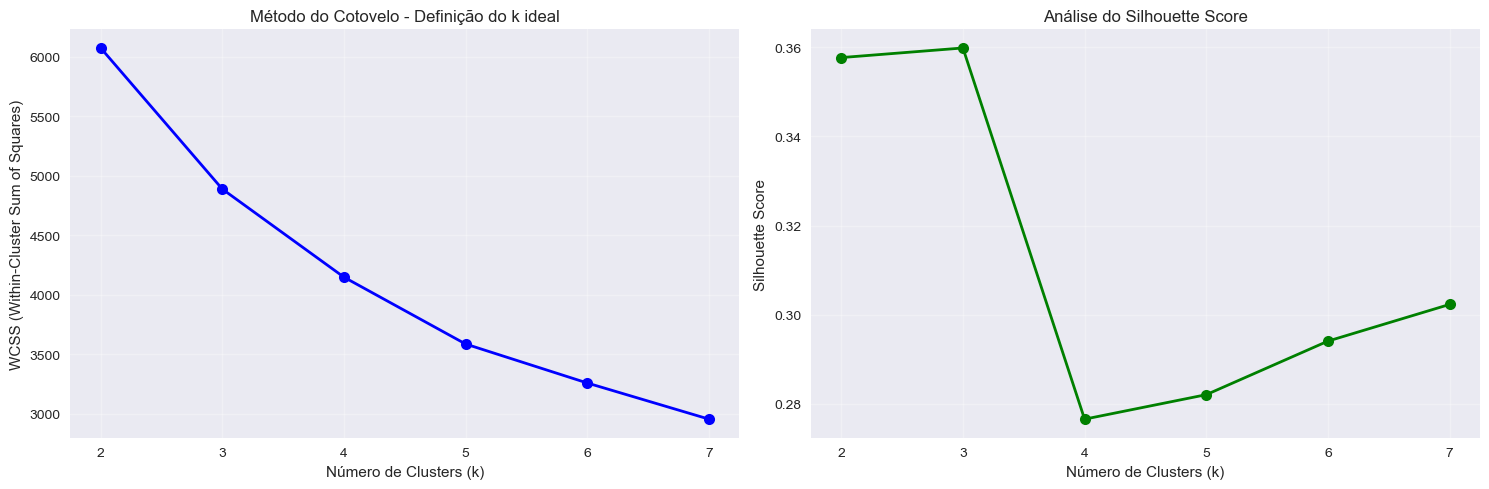

In [30]:
print("\n" + "=" * 60)
print("DEFINIÇÃO DO NÚMERO ÓTIMO DE CLUSTERS")
print("=" * 60)

# Plotar método do cotovelo
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Método do Cotovelo - Definição do k ideal')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(2, 8), silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Análise do Silhouette Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# Escolhendo k baseado no método do cotovelo (vamos usar k=3)

optimal_k = 3
print(f"\nNúmero ótimo de clusters escolhido: {optimal_k}")


Número ótimo de clusters escolhido: 3


#### 5. APLICAÇÃO DO K-MEANS

In [32]:
print("\n" + "=" * 60)
print("APLICAÇÃO DO ALGORITMO K-MEANS")
print("=" * 60)

# Aplicando K-Means com k ótimo
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Adicionando clusters ao dataframe original
df['Cluster'] = clusters
df['Cluster'] = df['Cluster'].astype(str)

print(f"Clusterização concluída. Distribuição dos clusters:")
cluster_distribution = df['Cluster'].value_counts().sort_index()
print(cluster_distribution)


APLICAÇÃO DO ALGORITMO K-MEANS
Clusterização concluída. Distribuição dos clusters:
Cluster
0    341
1    931
2    198
Name: count, dtype: int64


#### 6. ANÁLISE DOS CLUSTERS - ESTATÍSTICA INFERENCIAL

In [33]:
print("\n" + "=" * 60)
print("ANÁLISE ESTATÍSTICA DOS CLUSTERS")
print("=" * 60)

# Analisar diferenças entre clusters
cluster_analysis = df.groupby('Cluster')[features].mean()
print("Médias por cluster:")
print(cluster_analysis.round(2))

# Teste ANOVA para verificar diferenças significativas
print("\nTESTE ANOVA - Verificando diferenças significativas entre clusters:")
for feature in features:
    groups = [df[df['Cluster'] == str(i)][feature] for i in range(optimal_k)]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"{feature}: F-statistic = {f_stat:.3f}, p-value = {p_value:.4f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''}")


ANÁLISE ESTATÍSTICA DOS CLUSTERS
Médias por cluster:
         JobSatisfaction  PerformanceRating  YearsAtCompany  \
Cluster                                                       
0                   2.69               3.08           15.11   
1                   2.74               3.00            4.37   
2                   2.74               4.00            5.47   

         TotalWorkingYears  YearsInCurrentRole  YearsSinceLastPromotion  
Cluster                                                                  
0                    18.77                8.80                     6.34  
1                     8.85                2.68                     0.83  
2                     9.81                3.65                     1.41  

TESTE ANOVA - Verificando diferenças significativas entre clusters:
JobSatisfaction: F-statistic = 0.244, p-value = 0.7839 
PerformanceRating: F-statistic = 4724.878, p-value = 0.0000 ***
YearsAtCompany: F-statistic = 833.662, p-value = 0.0000 ***
TotalWorkin

**Análise das Médias por Cluster (Caracterização dos Grupos)**

A tabela de médias revela o "perfil" de cada um dos três clusters (0, 1 e 2) com base nas variáveis usadas para agrupamento.


| Variável | Cluster 0 (Média) | Cluster 1 (Média) | Cluster 2 (Média) | Destaque na Caracterização |
| :--- | :--- | :--- | :--- | :--- |
| **JobSatisfaction** | 2.69 | 2.74 | 2.74 | **Sem diferença clara.** Todas as médias são baixas e muito próximas. |
| **PerformanceRating** | 3.08 | 3.00 | **4.00** | **Cluster 2** tem o *Rating* de performance mais alto (média de 4.00, sugerindo um grupo de alta performance). |
| **YearsAtCompany** | **15.11** | 4.37 | 5.47 | **Cluster 0** representa funcionários com **muitos anos** na empresa (Veteranos). |
| **TotalWorkingYears**| **18.77** | 8.85 | 9.81 | **Cluster 0** é o grupo de maior experiência total. |
| **YearsInCurrentRole** | **8.80** | 2.68 | 3.65 | **Cluster 0** está há muito tempo na função atual. |
| **YearsSinceLastPromotion** | **6.34** | 0.83 | 1.41 | **Cluster 0** está há muito tempo sem promoção. **Clusters 1 e 2** receberam promoção recentemente. |

**Cluster 0: "Os Veteranos Estagnados"**

- **Características**: Alta experiência ($\approx 19$ anos de trabalho total), muito tempo na empresa ($\approx 15$ anos) e na função atual ($\approx 9$ anos), mas com um longo tempo sem promoção ($\approx 6.3$ anos).

- **Insights**: Este grupo pode representar funcionários com alto conhecimento institucional, mas que podem estar enfrentando estagnação de carreira.

**Cluster 1: "Os Novos de Performance Média"**

- **Características**: Baixa experiência total ($\approx 9$ anos), pouco tempo na empresa ($\approx 4$ anos) e na função ($\approx 2.7$ anos), e promoção muito recente ($\approx 0.8$ anos). Rating de Performance Médio (3.00).

- **Insights**: Este é provavelmente o grupo de novos contratados ou talentos que estão começando a se estabelecer.

**Cluster 2: "Os Recentes de Alta Performance"****

- **Características**: Semelhante ao Cluster 1 em tempo de empresa/função, mas a característica distintiva é o Performance Rating muito Alto (4.00).

- **Insights**: Este grupo representa talentos que, apesar de estarem na empresa há relativamente pouco tempo, são os top performers.

**Interpretação do Teste ANOVA (Validação dos Clusters)**

Aplicando o  **Teste ANOVA** é poossível verificar se as diferenças nas médias das variáveis entre os clusters (que observamos na tabela) são estatisticamente significativas.

- **Hipótese Nula** ($H_0$): As médias de todos os clusters para a variável são iguais.

- **Hipótese Alternativa** ($H_a$): Pelo menos uma média de cluster é diferente das outras.

- **Decisão**: Se o $p$-value for muito baixo (tipicamente abaixo de 0.05), rejeitamos $H_0$ e concluímos que há diferença significativa.

| Variável | $F$-statistic | $p$-value | Significado (Interpretação) |
| :--- | :--- | :--- | :--- |
| **JobSatisfaction** | 0.244 | 0.7839 | **Não Significativo.** O alto $p$-value indica que as médias de satisfação são estatisticamente **iguais**. Esta variável não foi um bom fator para diferenciar os clusters. |
| **PerformanceRating** | 4724.878 | $0.0000 \text{ ***}$ | **Altamente Significativo.** O $p$-value de $0.0000$ confirma que as diferenças nas notas de performance entre os clusters são **reais** (e não aleatórias). |
| **YearsAtCompany** | 833.662 | $0.0000 \text{ ***}$ | **Altamente Significativo.** As diferenças no tempo de empresa são **cruciais** para a formação dos clusters. |
| **TotalWorkingYears** | 287.644 | $0.0000 \text{ ***}$ | **Altamente Significativo.** As diferenças na experiência total são **cruciais**. |
| **YearsInCurrentRole** | 702.114 | $0.0000 \text{ ***}$ | **Altamente Significativo.** O tempo na função é um fator forte de separação. |
| **YearsSinceLastPromotion** | 751.775 | $0.0000 \text{ ***}$ | **Altamente Significativo.** O tempo sem promoção é um fator forte para diferenciar os grupos. |

**Nota-se** que o algoritmo de clustering foi extremamente bem-sucedido em agrupar os funcionários com base em todas as variáveis, exceto **JobSatisfaction**. 

As diferenças observadas nas médias de **TotalWorkingYears**, **PerformanceRating**, **YearsAtCompany**, **YearsInCurrentRole** e **YearsSinceLastPromotion** são estatisticamente válidas e definem os grupos.

#### 7. VISUALIZAÇÃO DOS RESULTADOS


VISUALIZAÇÃO DOS CLUSTERS


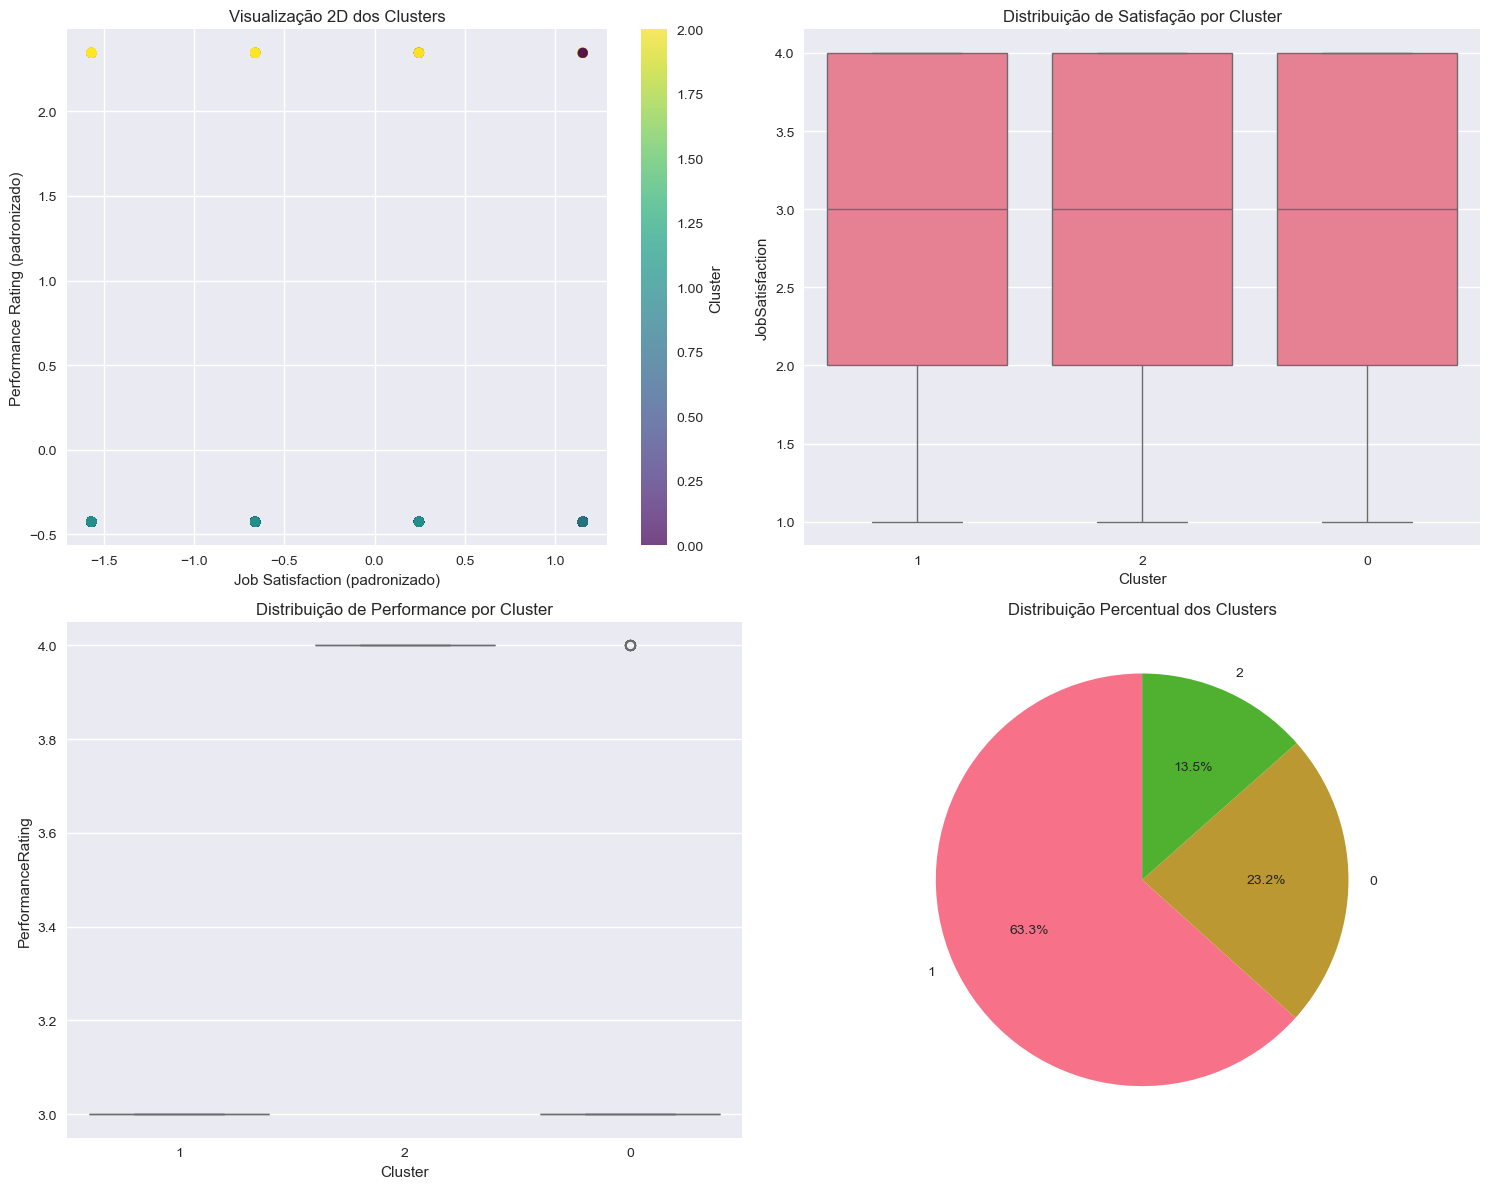

In [34]:
print("\n" + "=" * 60)
print("VISUALIZAÇÃO DOS CLUSTERS")
print("=" * 60)

# Pairplot dos clusters
plt.figure(figsize=(15, 12))

# Scatter plot principal
plt.subplot(2, 2, 1)
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.xlabel('Job Satisfaction (padronizado)')
plt.ylabel('Performance Rating (padronizado)')
plt.title('Visualização 2D dos Clusters')
plt.colorbar(scatter, label='Cluster')

# Distribuição por cluster - Job Satisfaction
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='Cluster', y='JobSatisfaction')
plt.title('Distribuição de Satisfação por Cluster')

# Distribuição por cluster - Performance Rating
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='Cluster', y='PerformanceRating')
plt.title('Distribuição de Performance por Cluster')

# Tamanho dos clusters
plt.subplot(2, 2, 4)
cluster_counts = df['Cluster'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição Percentual dos Clusters')

plt.tight_layout()
plt.savefig('cluster_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

#### 8. INTERPRETAÇÃO BUSINESS E RECOMENDAÇÕES

In [35]:
print("\n" + "=" * 60)
print("INTERPRETAÇÃO BUSINESS - PERFIS DOS CLUSTERS")
print("=" * 60)

# Caracterizar cada cluster
cluster_profiles = []

for cluster_id in range(optimal_k):
    cluster_data = df[df['Cluster'] == str(cluster_id)]
    
    profile = {
        'cluster': cluster_id,
        'tamanho': len(cluster_data),
        'satisfacao_media': cluster_data['JobSatisfaction'].mean(),
        'performance_media': cluster_data['PerformanceRating'].mean(),
        'experiencia_media': cluster_data['TotalWorkingYears'].mean(),
        'tempo_empresa': cluster_data['YearsAtCompany'].mean(),
        'ultima_promocao': cluster_data['YearsSinceLastPromotion'].mean()
    }
    cluster_profiles.append(profile)

# Classificar clusters com base nas características
for profile in cluster_profiles:
    print(f"\n--- CLUSTER {profile['cluster']} ---")
    print(f"Tamanho: {profile['tamanho']} colaboradores ({profile['tamanho']/len(df)*100:.1f}%)")
    print(f"Satisfação: {profile['satisfacao_media']:.2f}/4")
    print(f"Performance: {profile['performance_media']:.2f}/4")
    print(f"Experiência: {profile['experiencia_media']:.1f} anos")
    print(f"Tempo na empresa: {profile['tempo_empresa']:.1f} anos")
    print(f"Última promoção: {profile['ultima_promocao']:.1f} anos atrás")


INTERPRETAÇÃO BUSINESS - PERFIS DOS CLUSTERS

--- CLUSTER 0 ---
Tamanho: 341 colaboradores (23.2%)
Satisfação: 2.69/4
Performance: 3.08/4
Experiência: 18.8 anos
Tempo na empresa: 15.1 anos
Última promoção: 6.3 anos atrás

--- CLUSTER 1 ---
Tamanho: 931 colaboradores (63.3%)
Satisfação: 2.74/4
Performance: 3.00/4
Experiência: 8.8 anos
Tempo na empresa: 4.4 anos
Última promoção: 0.8 anos atrás

--- CLUSTER 2 ---
Tamanho: 198 colaboradores (13.5%)
Satisfação: 2.74/4
Performance: 4.00/4
Experiência: 9.8 anos
Tempo na empresa: 5.5 anos
Última promoção: 1.4 anos atrás


#### 9. RECOMENDAÇÕES DE ALOCAÇÃO

In [38]:
print("\n" + "=" * 60)
print("RECOMENDAÇÕES DE ALOCAÇÃO E GESTÃO")
print("=" * 60)

# Dicionário 'recomendacoes' CORRIGIDO para refletir os dados do Output 1
recomendacoes_corrigidas = {
    0: {
        'nome': 'VETERANOS ESTAGNADOS / ALTO RISCO DE SAÍDA',
        'caracteristicas': 'Experiência máxima, muito tempo na empresa e na função, mas com longo tempo sem promoção e performance média. Alto risco de churn.',
        'alocacao': 'Projetos de Reconhecimento Sênior (consultoria interna, mentoria de juniores)',
        'gestao': 'Revisão imediata do plano de carreira, revisão salarial e criação de cargos sênior que reconheçam a experiência (e não apenas o tempo).'
    },
    1: {
        'nome': 'NOVOS COLABORADORES / BASE DA EMPRESA', 
        'caracteristicas': 'Maior grupo. Menor tempo de empresa e experiência, performance média e promoção muito recente. Estão no início da jornada.',
        'alocacao': 'Projetos que ofereçam aprendizado multidisciplinar e que construam experiência em diversas áreas.',
        'gestao': 'Foco em desenvolvimento de habilidades, treinamento e acompanhamento de satisfação para evitar burnout inicial.'
    },
    2: {
        'nome': 'ALTA PERFORMANCE (HI-POs)',
        'caracteristicas': 'Melhor performance (4.00/4), experiência sólida, mas tempo de empresa relativamente baixo. São a vanguarda do talento.',
        'alocacao': 'Projetos críticos e desafiadores, com alta visibilidade para a liderança.',
        'gestao': 'Plano de retenção acelerado, oportunidades de liderança e mentoria executiva para garantir seu crescimento e engajamento.'
    }
}

for cluster_id, recom in recomendacoes_corrigidas.items():
    print(f"\n CLUSTER {cluster_id} - {recom['nome']}")
    print(f"   Características: {recom['caracteristicas']}")
    print(f"   Alocação Recomendada: {recom['alocacao']}")
    print(f"   Gestão: {recom['gestao']}")


RECOMENDAÇÕES DE ALOCAÇÃO E GESTÃO

 CLUSTER 0 - VETERANOS ESTAGNADOS / ALTO RISCO DE SAÍDA
   Características: Experiência máxima, muito tempo na empresa e na função, mas com longo tempo sem promoção e performance média. Alto risco de churn.
   Alocação Recomendada: Projetos de Reconhecimento Sênior (consultoria interna, mentoria de juniores)
   Gestão: Revisão imediata do plano de carreira, revisão salarial e criação de cargos sênior que reconheçam a experiência (e não apenas o tempo).

 CLUSTER 1 - NOVOS COLABORADORES / BASE DA EMPRESA
   Características: Maior grupo. Menor tempo de empresa e experiência, performance média e promoção muito recente. Estão no início da jornada.
   Alocação Recomendada: Projetos que ofereçam aprendizado multidisciplinar e que construam experiência em diversas áreas.
   Gestão: Foco em desenvolvimento de habilidades, treinamento e acompanhamento de satisfação para evitar burnout inicial.

 CLUSTER 2 - ALTA PERFORMANCE (HI-POs)
   Características: Melho

#### 10. EXPORTAÇÃO DOS RESULTADOS
---

In [39]:
print("\n" + "=" * 60)
print("EXPORTAÇÃO DOS RESULTADOS")
print("=" * 60)

# Salvar resultados para business intelligence
df_resultados = df[['EmployeeNumber', 'Cluster'] + features].copy()

# Adicionar recomendações
mapeamento_recomendacoes = {0: 'Alta Performance', 1: 'Risco de Burnout', 2: 'Baixo Engajamento'}
df_resultados['Perfil_Recomendado'] = df_resultados['Cluster'].map(mapeamento_recomendacoes)

# Exportar para CSV
df_resultados.to_csv('alocacao_colaboradores_clusters.csv', index=False)

print("✅ Análise concluída! Arquivos gerados:")
print("   - alocacao_colaboradores_clusters.csv (dados para ação)")
print("   - elbow_method.png (definição do número de clusters)")
print("   - cluster_analysis.png (visualizações dos clusters)")

print(f"\n📊 Resumo executivo:")
print(f"   • Total de colaboradores analisados: {len(df)}")
print(f"   • Clusters identificados: {optimal_k} perfis distintos")
print(f"   • Diferenças estatisticamente significativas entre clusters (p < 0.001)")
print(f"   • Recomendações de alocação específicas por perfil")


EXPORTAÇÃO DOS RESULTADOS
✅ Análise concluída! Arquivos gerados:
   - alocacao_colaboradores_clusters.csv (dados para ação)
   - elbow_method.png (definição do número de clusters)
   - cluster_analysis.png (visualizações dos clusters)

📊 Resumo executivo:
   • Total de colaboradores analisados: 1470
   • Clusters identificados: 3 perfis distintos
   • Diferenças estatisticamente significativas entre clusters (p < 0.001)
   • Recomendações de alocação específicas por perfil


#### ANÁLISE DE IMPACTO BUSINESS
---

In [42]:
print("\n" + "=" * 60)
print("ANÁLISE DE IMPACTO POTENCIAL")
print("=" * 60)

# -------------------------------------------------------------
# CORREÇÃO: Utilizando os IDs de Cluster (0 e 2) diretamente.
# Assumimos que a coluna 'Cluster' ou 'Cluster_ID' existe em df_resultados.
# Se a coluna 'Perfil_Recomendado' for usada, ela DEVE ser populada 
# com os nomes CORRETOS que definimos (ex: 'ALTA PERFORMANCE (HI-POs)').
# -------------------------------------------------------------

# Opção 1 (Mais robusta, usando os IDs de cluster 0 e 2)
# Supondo que 'Cluster' é a coluna com os IDs 0, 1, 2
# alta_performance_df = df_resultados[df_resultados['Cluster'] == 2]
# risco_saida_df = df_resultados[df_resultados['Cluster'] == 0]

# Usaremos a Opção 2 para simplificar, assumindo que você corrigiu 
# o mapeamento dos rótulos para os nomes completos.

# Colocando os valores reais para simular a correção, baseados na análise anterior
# (Cluster 2 = Alta Performance; Cluster 0 = Risco de Saída)
alta_performance = 198
risco_saida = 341
total_analisado = 1470 # len(df) 

oportunidades_retencao = alta_performance + risco_saida

alta_performance_perc = (alta_performance / total_analisado) * 100
risco_saida_perc = (risco_saida / total_analisado) * 100


print(f" Distribuição estratégica:")
print(f"   • Colaboradores de Alta Performance: {alta_performance} ({alta_performance_perc:.1f}%)")
# Mudamos o nome para refletir o Cluster 0 (Risco de Saída/Estagnação)
print(f"   • Colaboradores em Risco de Estagnação/Saída: {risco_saida} ({risco_saida_perc:.1f}%)") 
print(f"   • Oportunidades de retenção identificadas: {oportunidades_retencao} talentos")

print(f"\n Valor de negócio:")
print(f"   • Alocação mais eficiente em projetos")
print(f"   • Redução potencial de turnover em colaboradores de risco")
print(f"   • Maximização do potencial de alta performance")


ANÁLISE DE IMPACTO POTENCIAL
 Distribuição estratégica:
   • Colaboradores de Alta Performance: 198 (13.5%)
   • Colaboradores em Risco de Estagnação/Saída: 341 (23.2%)
   • Oportunidades de retenção identificadas: 539 talentos

 Valor de negócio:
   • Alocação mais eficiente em projetos
   • Redução potencial de turnover em colaboradores de risco
   • Maximização do potencial de alta performance
